In [1]:
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import itertools
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
# constructs a 1D sparse centered difference operator
def centered_finite_difference_1d(N):
    cols = list(itertools.chain(range(1,N),range(N-1)))
    rows = list(itertools.chain(range(N-1),range(N-1)))
    values = [1 for _ in range(N-1)] + [-1 for _ in range(N-1)]
    return sp.sparse.coo_matrix((values,(rows,cols)),shape=(N-1,N))

In [3]:
N = 40
dt = 1. / N
D = centered_finite_difference_1d(N)
print(D.shape)
L = 1./dt**2 * D.transpose() * D

(39, 40)


In [4]:
L.todense()

matrix([[ 1600., -1600.,     0., ...,     0.,     0.,     0.],
        [-1600.,  3200., -1600., ...,     0.,     0.,     0.],
        [    0., -1600.,  3200., ...,     0.,     0.,     0.],
        ...,
        [    0.,     0.,     0., ...,  3200., -1600.,     0.],
        [    0.,     0.,     0., ..., -1600.,  3200., -1600.],
        [    0.,     0.,     0., ...,     0., -1600.,  1600.]])

In [5]:
x = np.linspace(0,1,N)

In [6]:
u = np.sin(4 * np.pi * x)

u = 2*np.exp(-(x-.5)**2 / (.1**2))
up = 2*np.exp(-(x-.51)**2 / (.1**2))

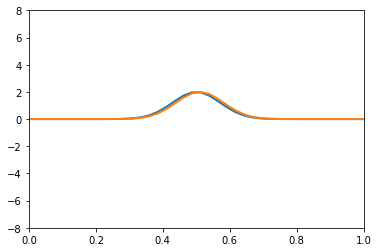

In [7]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 1))
ax.set_ylim((-8, 8))

line, = ax.plot(x, u, lw=2)
line2, = ax.plot(x, up, lw=2)


In [8]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line2.set_data([], [])
    return (line,line2)

In [9]:
dt = .1
c = .1
# animation function. This is called sequentially
def animate_explicit_stormer_verlet(i,data):
    u,up = data
    # standard stormer explicit stormer verlet
    # u_{t+1} - 2 u_{t} + u_{t-1} = -dt^2 c^2 \Delta (u_{t})
    u,up = 2 * u - up - dt**2 * c**2 * L * u, u
    line.set_data(x, u)
    line2.set_data(x, up)
    data[:] = [u,up]
    return (line,line2)

    

In [10]:
anim = animation.FuncAnimation(fig, animate_explicit_stormer_verlet, init_func=init,fargs=([u,up],),
                               frames=500, interval=20, blit=True)
HTML(anim.to_html5_video())

In [11]:
dt = .1
c = .1
# animation function. This is called sequentially
def animate_implicit_stormer_verlet(i,data):
    u,up = data
    # second order centered difference
    # u_{t+1} - 2 u_{t} + u_{t-1} = -dt^2 c^2 \Delta (u_{t+1} + u_{t-1})/2
    b = 2 * u - up - .5 * dt**2 * c**2 * L * up
    A = sp.sparse.identity(N) + .5 * dt**2 * c**2 * L
    un,suc = sp.sparse.linalg.cg(A,b)
    u,up = un,u
    line.set_data(x, u)
    line2.set_data(x, up)
    data[:] = [u,up]
    return (line,line2)

    

In [12]:
anim = animation.FuncAnimation(fig, animate_implicit_stormer_verlet, init_func=init,fargs=([u,up],),
                               frames=500, interval=20, blit=True)
HTML(anim.to_html5_video())

In [13]:
# constructs a 1D sparse centered difference operator
def centered_finite_difference_2d(N,M):
    
    # i,j on N,M -> i + j*N
    Dx = centered_finite_difference_1d(N)
    Dy = centered_finite_difference_1d(M)
    x_size = M*(N-1)
    y_size = N*(M-1)
    oxrow = type(Dx.row)
    print(x_size,y_size)
    # r -> r,m -> r + m * N
    xrows = [v + m*(N-1) for m in range(M) for v in Dx.row ]
    xcols = [v + m*N for m in range(M) for v in Dx.col ]
    xvalues = [v for m in range(M) for v in Dx.data ]
    print("DX SHAPE:",Dx.shape)
    print("DY SHAPE:",Dy.shape)
    print(Dy.row)
    print(Dy.col)
    print(Dy.data)
    
    # c -> n,c -> n + c * N
    yrows = [v * (N-1) + n + x_size for n in range(N) for v in Dy.row ]
    ycols = [v * N + n for n in range(N) for v in Dy.col ]
    yvalues = [v for n in range(N) for v in Dy.data ]
    
    
    rows = np.hstack((xrows,yrows))
    cols = np.hstack((xcols,ycols))
    values = np.hstack((xvalues,yvalues))
    print(rows)
    print(cols)
    print(values)
    shape = (x_size+y_size,N*M)
    print(shape)
    return sp.sparse.coo_matrix((values,(rows,cols)),shape=shape)

    

In [14]:

D = centered_finite_difference_2d(3,3)
print(D.todense())
L = D.transpose() * D
print(L.todense())

6 6
DX SHAPE: (2, 3)
DY SHAPE: (2, 3)
[0 1 0 1]
[1 2 0 1]
[ 1  1 -1 -1]
[ 0  1  0  1  2  3  2  3  4  5  4  5  6  8  6  8  7  9  7  9  8 10  8 10]
[1 2 0 1 4 5 3 4 7 8 6 7 3 6 0 3 4 7 1 4 5 8 2 5]
[ 1  1 -1 -1  1  1 -1 -1  1  1 -1 -1  1  1 -1 -1  1  1 -1 -1  1  1 -1 -1]
(12, 9)
[[-1  1  0  0  0  0  0  0  0]
 [ 0 -1  1  0  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0  0  0]
 [ 0  0  0  0 -1  1  0  0  0]
 [ 0  0  0  0  0  0 -1  1  0]
 [ 0  0  0  0  0  0  0 -1  1]
 [-1  0  0  1  0  0  0  0  0]
 [ 0 -1  0  0  1  0  0  0  0]
 [ 0  0 -1 -1  0  1  1  0  0]
 [ 0  0  0  0 -1  0  0  1  0]
 [ 0  0  0  0  0 -1  0  0  1]
 [ 0  0  0  0  0  0  0  0  0]]
[[ 2 -1  0 -1  0  0  0  0  0]
 [-1  3 -1  0 -1  0  0  0  0]
 [ 0 -1  2  1  0 -1 -1  0  0]
 [-1  0  1  3 -1 -1 -1  0  0]
 [ 0 -1  0 -1  4 -1  0 -1  0]
 [ 0  0 -1 -1 -1  3  1  0 -1]
 [ 0  0 -1 -1  0  1  2 -1  0]
 [ 0  0  0  0 -1  0 -1  3 -1]
 [ 0  0  0  0  0 -1  0 -1  2]]


In [15]:
N = 50
M = 50
x,y = np.linspace(0,1,N),np.linspace(0,1,M)
xy = np.array(np.meshgrid(x,y))
dxy = np.array([1./N,1./M])

D = centered_finite_difference_2d(N,M)
L = D.transpose() * D / dxy.prod()


2450 2450
DX SHAPE: (49, 50)
DY SHAPE: (49, 50)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1]
[   0    1    2 ... 4753 4802 4851]
[   1    2    3 

In [16]:
u = 2*np.exp(-np.linalg.norm(xy-.5,axis=0)**2 / (.1**2))
up = 2*np.exp(-np.linalg.norm(xy-.5,axis=0)**2 / (.11**2))

In [17]:
u.reshape((-1))

array([3.85749970e-22, 2.84795487e-21, 1.93456877e-20, ...,
       1.93456877e-20, 2.84795487e-21, 3.85749970e-22])

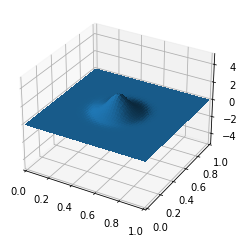

In [18]:
# First set up the figure, the axis, and the plot element we want to animate
#fig, ax = plt.subplots()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_xlim(( 0, 1))
ax.set_ylim(( 0, 1))
ax.set_zlim((-5,5))
surf = ax.plot_surface(*xy,u,
                       linewidth=0, antialiased=False)
un = u.reshape((1,N,M))

v = np.stack((*xy,u))
v = v.transpose(1,2,0)
#surf.set_verts(v)


In [19]:
# initialization function: plot the background of each frame
def init():
    surf.set_verts([], [],[])
    return (surf,)

u = 2*np.exp(-np.linalg.norm(xy-.5,axis=0)**2 / (.05**2))
up = 2*np.exp(-np.linalg.norm(xy-.5,axis=0)**2 / (.051**2))
print(u.shape)

(50, 50)


In [23]:
dt = .1
c = .1

states = [(u,up)]
# animation function. This is called sequentially
for m in range(50000):
    u,up = states[-1]
    # standard stormer explicit stormer verlet
    # u_{t+1} - 2 u_{t} + u_{t-1} = -dt^2 c^2 \Delta (u_{t})
    ushape = u.shape
    Lu = L * u.reshape((-1))
    u,up = 2 * u - up - dt**2 * c**2 * (Lu).reshape(ushape), u
    states.append((u,up))

states = states[:500:]

[[-0.40374071 -0.33062284 -0.26011744 ... -0.22458643 -0.24067514
  -0.21108326]
 [-0.40050174 -0.29885626 -0.23957927 ... -0.28342014 -0.34307215
  -0.44683357]
 [-0.17688816 -0.21082577 -0.20610097 ... -0.32272024 -0.38240898
  -0.47019638]
 ...
 [-0.47019638 -0.38240898 -0.32272024 ... -0.20610097 -0.21082577
  -0.17688816]
 [-0.44683357 -0.34307215 -0.28342014 ... -0.23957927 -0.29885626
  -0.40050174]
 [-0.21108326 -0.24067514 -0.22458643 ... -0.26011744 -0.33062284
  -0.40374071]]


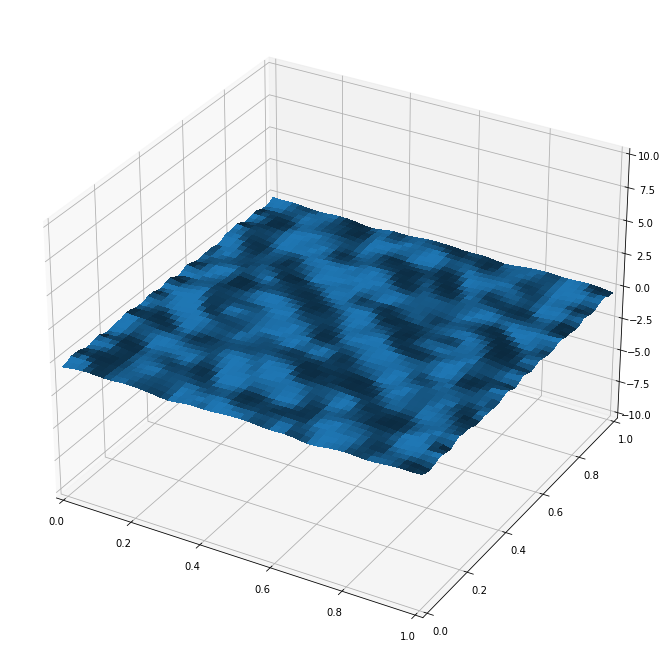

In [21]:
# First set up the figure, the axis, and the plot element we want to animate
#fig, ax = plt.subplots()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(12,12))
ax.set_xlim(( 0, 1))
ax.set_ylim(( 0, 1))
ax.set_zlim((-10,10))
u,up = states[-1]
ushape = u.shape

Lu = L * u.reshape((-1))
z = dt * Lu.reshape(ushape)
surf = ax.plot_surface(*xy,u,
                       linewidth=0, antialiased=False)
print(u)


Frame 0/500
Frame 0/500
Frame 0/500
Frame 1/500
Frame 2/500
Frame 3/500
Frame 4/500
Frame 5/500
Frame 6/500
Frame 7/500
Frame 8/500
Frame 9/500
Frame 10/500
Frame 11/500
Frame 12/500
Frame 13/500
Frame 14/500
Frame 15/500
Frame 16/500
Frame 17/500
Frame 18/500
Frame 19/500
Frame 20/500
Frame 21/500
Frame 22/500
Frame 23/500
Frame 24/500
Frame 25/500
Frame 26/500
Frame 27/500
Frame 28/500
Frame 29/500
Frame 30/500
Frame 31/500
Frame 32/500
Frame 33/500
Frame 34/500
Frame 35/500
Frame 36/500
Frame 37/500
Frame 38/500
Frame 39/500
Frame 40/500
Frame 41/500
Frame 42/500
Frame 43/500
Frame 44/500
Frame 45/500
Frame 46/500
Frame 47/500
Frame 48/500
Frame 49/500
Frame 50/500
Frame 51/500
Frame 52/500
Frame 53/500
Frame 54/500
Frame 55/500
Frame 56/500
Frame 57/500
Frame 58/500
Frame 59/500
Frame 60/500
Frame 61/500
Frame 62/500
Frame 63/500
Frame 64/500
Frame 65/500
Frame 66/500
Frame 67/500
Frame 68/500
Frame 69/500
Frame 70/500
Frame 71/500
Frame 72/500
Frame 73/500
Frame 74/500
Frame 75/50

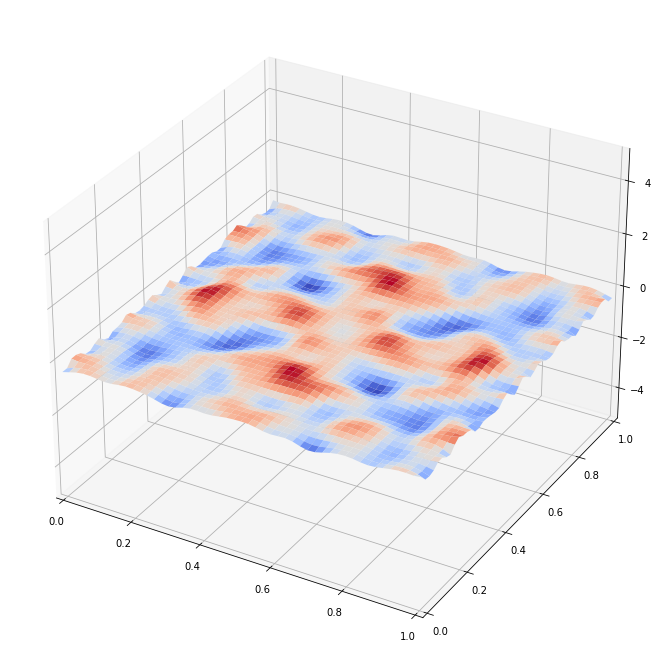

In [22]:
# First set up the figure, the axis, and the plot element we want to animate
#fig, ax = plt.subplots()
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(12,12))
ax.set_xlim(( 0, 1))
ax.set_ylim(( 0, 1))
ax.set_zlim((-5,5))
def animate(frame_num, zarr, plot):
    print("Frame {}/{}".format(frame_num,len(zarr)))
    plot[0].remove()
    
    plot[0] = ax.plot_surface(*xy, zarr[frame_num][0],cmap=cm.coolwarm)
    return (plot[0],)


plot = [ax.plot_surface(*xy, states[0][0], color='0.75', rstride=1, cstride=1)]

anim = animation.FuncAnimation(fig, animate, fargs=(states,plot),
                               frames=len(states), interval=20, blit=True)
HTML(anim.to_html5_video())